# Learning to Play the Zoning Game: Supervised

Let's actually do some machine learning. Here, we will train a neural network to mimic a greedy policy and a greedy value function by supervised learning. We will play a bunch of random games and take the output of some greedy policy (either `polich_indiv_greedy` or `policy_total_greedy`), alongside the "current grid score," as training data for a neural network with a policy head and a value head.

In [1]:
import logging
from multiprocessing import Pool

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from nsai_experiments.zoning_game.zg_gym import ZoningGameEnv, flatten_zg_obs, Tile
from nsai_experiments.zoning_game.zg_policy import create_policy_random

from nsai_experiments.zoning_game.notebook_utils import create_dataset_1_one_game

In [2]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

## Part 1: no streaming, random policy, only train value
Here, we focus on a single-headed value network and we use a pre-determined policy to generate a bunch of data ahead of time.

In [3]:
shuffle_before_split = True
valid_frac = 0.15
test_frac = 0.15

def create_dataset_1(policy_creator, n_games = 10_000):
    states = []
    values = []
    with Pool() as pool:
        # Due to a limitation in `multiprocessing` we had to define `create_dataset_1_one_game` in a separate file
        # (see https://stackoverflow.com/questions/41385708/)
        results = pool.starmap(create_dataset_1_one_game,
                               [(policy_creator, game_i+n_games, game_i) for game_i in range(n_games)])
    for my_states, my_values in results:
        states.extend(my_states)
        values.extend(my_values)
    return np.array(states), np.array(values)

states, values = create_dataset_1(create_policy_random)
print(states.shape)
print(values.shape)

states_tensor = torch.tensor(states, dtype=torch.long)
values_tensor = torch.tensor(values, dtype=torch.float32)

full_dataset = TensorDataset(states_tensor, values_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset))
    full_dataset = TensorDataset(states_tensor[indices], values_tensor[indices])

valid_size = int(valid_frac * len(full_dataset))
test_size = int(test_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size - test_size

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

print(f"Train size: {len(train_dataset)}, validation size: {len(valid_dataset)}, test size: {len(test_dataset)}")

(216143, 72)
(216143,)
Train size: 151301, validation size: 32421, test size: 32421


In [4]:
class StepOneValueNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()

        input_length = grid_size*grid_size*2
        one_hot_length = input_length * len(Tile)  # 432

        # n_hidden_1 = one_hot_length*2
        # n_hidden_2 = one_hot_length
        # n_hidden_3 = input_length
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden_1),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_1, n_hidden_2),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_2, n_hidden_3),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_3, 1)
        # )

        n_hidden = 2592
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(one_hot_length, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

    def forward(self, x):
        x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        x = torch.flatten(x, start_dim=1)
        x = self.linear_relu_stack(x)
        return x

In [5]:
def train_step_one_value_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 1e-4, weight_decay = 5e-2, device = DEVICE):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        abs_differences = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
                abs_differences.extend(torch.abs(outputs.squeeze() - targets).cpu().numpy())

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Calculate max, min, and mean absolute differences
        max_abs_diff = np.max(abs_differences)
        min_abs_diff = np.min(abs_differences)
        mean_abs_diff = np.mean(abs_differences)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Max Abs Diff: {max_abs_diff:.4f}, Min Abs Diff: {min_abs_diff:.4f}, Mean Abs Diff: {mean_abs_diff:.4f}")

    return model, train_mini_losses, train_losses, valid_losses

def plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = False):
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label='Train Mini Loss', s=5, color='gray')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    if log_scale: plt.yscale('log')
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 148/148 [00:04<00:00, 32.53it/s]


Epoch 1/50, Train Loss: 125.6175, Val Loss: 78.8551, Max Abs Diff: 46.2591, Min Abs Diff: 0.0003, Mean Abs Diff: 6.8728


100%|██████████| 148/148 [00:03<00:00, 37.34it/s]


Epoch 2/50, Train Loss: 55.9615, Val Loss: 28.1839, Max Abs Diff: 31.8287, Min Abs Diff: 0.0001, Mean Abs Diff: 4.1477


100%|██████████| 148/148 [00:03<00:00, 37.73it/s]


Epoch 3/50, Train Loss: 21.4754, Val Loss: 15.1860, Max Abs Diff: 26.7161, Min Abs Diff: 0.0001, Mean Abs Diff: 3.0808


100%|██████████| 148/148 [00:04<00:00, 36.67it/s]


Epoch 4/50, Train Loss: 13.9760, Val Loss: 9.3537, Max Abs Diff: 24.7551, Min Abs Diff: 0.0003, Mean Abs Diff: 2.3925


100%|██████████| 148/148 [00:03<00:00, 37.97it/s]


Epoch 5/50, Train Loss: 9.9799, Val Loss: 11.6345, Max Abs Diff: 23.2162, Min Abs Diff: 0.0001, Mean Abs Diff: 2.7372


100%|██████████| 148/148 [00:03<00:00, 37.98it/s]


Epoch 6/50, Train Loss: 9.3473, Val Loss: 5.7672, Max Abs Diff: 19.7680, Min Abs Diff: 0.0001, Mean Abs Diff: 1.8769


100%|██████████| 148/148 [00:03<00:00, 38.53it/s]


Epoch 7/50, Train Loss: 8.2389, Val Loss: 5.5596, Max Abs Diff: 14.8785, Min Abs Diff: 0.0001, Mean Abs Diff: 1.8549


100%|██████████| 148/148 [00:03<00:00, 37.61it/s]


Epoch 8/50, Train Loss: 7.3733, Val Loss: 5.2564, Max Abs Diff: 20.3269, Min Abs Diff: 0.0001, Mean Abs Diff: 1.7918


100%|██████████| 148/148 [00:03<00:00, 38.24it/s]


Epoch 9/50, Train Loss: 6.6697, Val Loss: 7.2874, Max Abs Diff: 16.1357, Min Abs Diff: 0.0001, Mean Abs Diff: 2.1627


100%|██████████| 148/148 [00:03<00:00, 38.53it/s]


Epoch 10/50, Train Loss: 7.4463, Val Loss: 5.1105, Max Abs Diff: 14.5623, Min Abs Diff: 0.0001, Mean Abs Diff: 1.7828


100%|██████████| 148/148 [00:03<00:00, 37.87it/s]


Epoch 11/50, Train Loss: 6.6938, Val Loss: 3.8861, Max Abs Diff: 14.7447, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5422


100%|██████████| 148/148 [00:03<00:00, 38.10it/s]


Epoch 12/50, Train Loss: 5.3006, Val Loss: 3.6033, Max Abs Diff: 17.2874, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4788


100%|██████████| 148/148 [00:03<00:00, 38.32it/s]


Epoch 13/50, Train Loss: 6.0717, Val Loss: 3.7370, Max Abs Diff: 15.9505, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5100


100%|██████████| 148/148 [00:03<00:00, 38.20it/s]


Epoch 14/50, Train Loss: 6.1101, Val Loss: 3.6423, Max Abs Diff: 13.7451, Min Abs Diff: 0.0001, Mean Abs Diff: 1.4984


100%|██████████| 148/148 [00:03<00:00, 38.67it/s]


Epoch 15/50, Train Loss: 4.9778, Val Loss: 3.4203, Max Abs Diff: 17.9413, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4414


100%|██████████| 148/148 [00:04<00:00, 34.84it/s]


Epoch 16/50, Train Loss: 5.5303, Val Loss: 3.3034, Max Abs Diff: 11.0603, Min Abs Diff: 0.0001, Mean Abs Diff: 1.4236


100%|██████████| 148/148 [00:03<00:00, 37.30it/s]


Epoch 17/50, Train Loss: 5.1868, Val Loss: 3.7028, Max Abs Diff: 16.9145, Min Abs Diff: 0.0000, Mean Abs Diff: 1.5103


100%|██████████| 148/148 [00:03<00:00, 37.32it/s]


Epoch 18/50, Train Loss: 5.3379, Val Loss: 27.1796, Max Abs Diff: 20.0768, Min Abs Diff: 0.0004, Mean Abs Diff: 4.6685


100%|██████████| 148/148 [00:03<00:00, 37.77it/s]


Epoch 19/50, Train Loss: 5.0675, Val Loss: 6.8648, Max Abs Diff: 18.1415, Min Abs Diff: 0.0000, Mean Abs Diff: 2.1117


100%|██████████| 148/148 [00:04<00:00, 37.00it/s]


Epoch 20/50, Train Loss: 6.3165, Val Loss: 3.1291, Max Abs Diff: 12.6328, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3848


100%|██████████| 148/148 [00:03<00:00, 37.84it/s]


Epoch 21/50, Train Loss: 4.4566, Val Loss: 10.7204, Max Abs Diff: 18.8096, Min Abs Diff: 0.0006, Mean Abs Diff: 2.7039


100%|██████████| 148/148 [00:03<00:00, 37.91it/s]


Epoch 22/50, Train Loss: 4.4085, Val Loss: 2.8444, Max Abs Diff: 12.9806, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3141


100%|██████████| 148/148 [00:03<00:00, 37.62it/s]


Epoch 23/50, Train Loss: 5.2238, Val Loss: 6.9446, Max Abs Diff: 14.2076, Min Abs Diff: 0.0001, Mean Abs Diff: 2.1615


100%|██████████| 148/148 [00:03<00:00, 38.32it/s]


Epoch 24/50, Train Loss: 4.0519, Val Loss: 3.3002, Max Abs Diff: 15.5485, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4305


100%|██████████| 148/148 [00:03<00:00, 37.86it/s]


Epoch 25/50, Train Loss: 5.1777, Val Loss: 2.8975, Max Abs Diff: 14.4451, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3285


100%|██████████| 148/148 [00:03<00:00, 38.46it/s]


Epoch 26/50, Train Loss: 4.6094, Val Loss: 9.0372, Max Abs Diff: 13.3680, Min Abs Diff: 0.0000, Mean Abs Diff: 2.4666


100%|██████████| 148/148 [00:03<00:00, 37.51it/s]


Epoch 27/50, Train Loss: 4.3599, Val Loss: 2.8024, Max Abs Diff: 10.4311, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3149


100%|██████████| 148/148 [00:03<00:00, 37.86it/s]


Epoch 28/50, Train Loss: 4.2608, Val Loss: 5.4689, Max Abs Diff: 12.2747, Min Abs Diff: 0.0000, Mean Abs Diff: 1.9227


100%|██████████| 148/148 [00:03<00:00, 37.54it/s]


Epoch 29/50, Train Loss: 4.8509, Val Loss: 2.9817, Max Abs Diff: 14.5788, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3498


100%|██████████| 148/148 [00:03<00:00, 37.58it/s]


Epoch 30/50, Train Loss: 5.2524, Val Loss: 2.7548, Max Abs Diff: 10.4916, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3029


100%|██████████| 148/148 [00:03<00:00, 38.14it/s]


Epoch 31/50, Train Loss: 3.5193, Val Loss: 3.1529, Max Abs Diff: 13.0021, Min Abs Diff: 0.0002, Mean Abs Diff: 1.3976


100%|██████████| 148/148 [00:03<00:00, 37.90it/s]


Epoch 32/50, Train Loss: 4.4938, Val Loss: 3.1293, Max Abs Diff: 9.5543, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3951


100%|██████████| 148/148 [00:03<00:00, 38.10it/s]


Epoch 33/50, Train Loss: 3.8689, Val Loss: 7.2295, Max Abs Diff: 17.0958, Min Abs Diff: 0.0003, Mean Abs Diff: 2.2537


100%|██████████| 148/148 [00:04<00:00, 35.29it/s]


Epoch 34/50, Train Loss: 3.9946, Val Loss: 4.1309, Max Abs Diff: 11.1564, Min Abs Diff: 0.0000, Mean Abs Diff: 1.6242


100%|██████████| 148/148 [00:04<00:00, 35.93it/s]


Epoch 35/50, Train Loss: 4.1939, Val Loss: 3.2095, Max Abs Diff: 12.8798, Min Abs Diff: 0.0000, Mean Abs Diff: 1.4123


100%|██████████| 148/148 [00:03<00:00, 37.11it/s]


Epoch 36/50, Train Loss: 4.2842, Val Loss: 2.8477, Max Abs Diff: 12.5555, Min Abs Diff: 0.0000, Mean Abs Diff: 1.3202


100%|██████████| 148/148 [00:03<00:00, 38.74it/s]


Epoch 37/50, Train Loss: 3.9296, Val Loss: 3.0769, Max Abs Diff: 14.8895, Min Abs Diff: 0.0001, Mean Abs Diff: 1.3801


100%|██████████| 148/148 [00:03<00:00, 37.68it/s]


Epoch 38/50, Train Loss: 3.7388, Val Loss: 2.4605, Max Abs Diff: 10.2061, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2243


100%|██████████| 148/148 [00:04<00:00, 36.07it/s]


Epoch 39/50, Train Loss: 4.4026, Val Loss: 2.5146, Max Abs Diff: 13.0058, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2398


100%|██████████| 148/148 [00:04<00:00, 36.44it/s]


Epoch 40/50, Train Loss: 3.5320, Val Loss: 2.5307, Max Abs Diff: 12.0817, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2410


100%|██████████| 148/148 [00:04<00:00, 36.16it/s]


Epoch 41/50, Train Loss: 3.9362, Val Loss: 2.5852, Max Abs Diff: 15.8072, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2549


100%|██████████| 148/148 [00:03<00:00, 37.31it/s]


Epoch 42/50, Train Loss: 3.4968, Val Loss: 3.1772, Max Abs Diff: 13.9856, Min Abs Diff: 0.0001, Mean Abs Diff: 1.4064


100%|██████████| 148/148 [00:04<00:00, 36.64it/s]


Epoch 43/50, Train Loss: 3.8938, Val Loss: 4.6484, Max Abs Diff: 14.4095, Min Abs Diff: 0.0002, Mean Abs Diff: 1.7205


100%|██████████| 148/148 [00:04<00:00, 33.54it/s]


Epoch 44/50, Train Loss: 3.8027, Val Loss: 3.7082, Max Abs Diff: 12.1642, Min Abs Diff: 0.0001, Mean Abs Diff: 1.5269


100%|██████████| 148/148 [00:04<00:00, 35.73it/s]


Epoch 45/50, Train Loss: 4.0532, Val Loss: 2.6735, Max Abs Diff: 13.4349, Min Abs Diff: 0.0002, Mean Abs Diff: 1.2752


100%|██████████| 148/148 [00:03<00:00, 38.24it/s]


Epoch 46/50, Train Loss: 3.4638, Val Loss: 3.6754, Max Abs Diff: 14.5822, Min Abs Diff: 0.0001, Mean Abs Diff: 1.5228


100%|██████████| 148/148 [00:03<00:00, 38.92it/s]


Epoch 47/50, Train Loss: 3.7454, Val Loss: 4.5943, Max Abs Diff: 14.6219, Min Abs Diff: 0.0001, Mean Abs Diff: 1.7267


100%|██████████| 148/148 [00:03<00:00, 38.60it/s]


Epoch 48/50, Train Loss: 3.7761, Val Loss: 2.4102, Max Abs Diff: 13.8789, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2119


100%|██████████| 148/148 [00:03<00:00, 38.20it/s]


Epoch 49/50, Train Loss: 4.1653, Val Loss: 2.3927, Max Abs Diff: 14.2082, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2087


100%|██████████| 148/148 [00:04<00:00, 36.97it/s]


Epoch 50/50, Train Loss: 3.4235, Val Loss: 2.4566, Max Abs Diff: 14.5332, Min Abs Diff: 0.0001, Mean Abs Diff: 1.2233


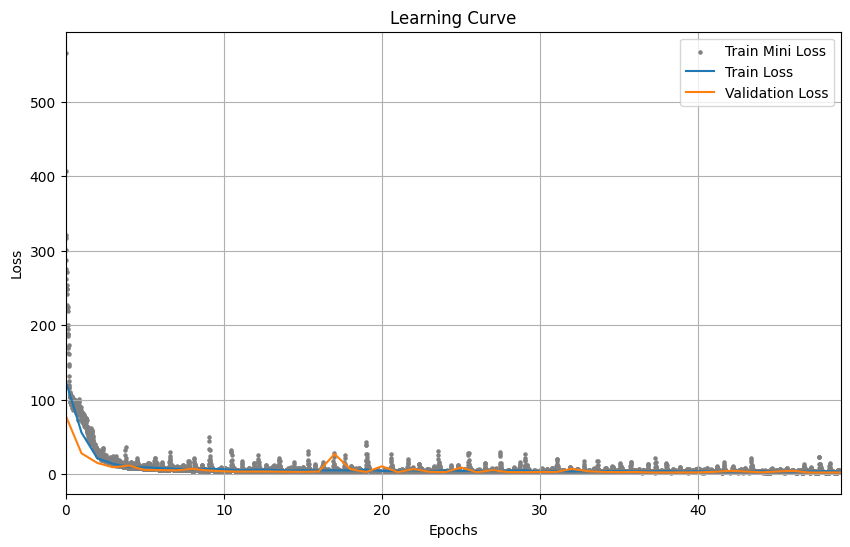

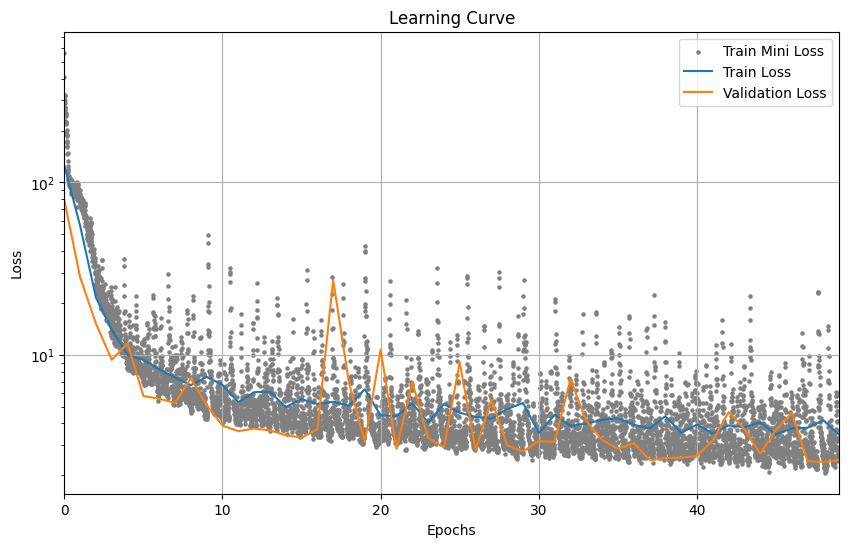

In [6]:
model = StepOneValueNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_one_value_network(model, train_dataset, valid_dataset, epochs = 50)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)